# Fruit Image Classification Using Transfer Learning (VGG16)

In this project I built an image classifier that can recognize 24 different fruit (and vegetable) categories from photos. Instead of training a deep neural network from scratch — which would require a massive dataset and a lot of compute — I used **transfer learning** with **VGG16**, a well-known convolutional neural network that was pre-trained on ImageNet (1.2 million images, 1000 classes).

The idea is simple: VGG16 already knows how to detect edges, textures, shapes and patterns. I kept all of that knowledge, chopped off its original classification head, and replaced it with my own layers trained specifically to tell fruits apart.

The pipeline goes like this:
1. Download and set up the Fruits-360 dataset
2. Build data generators with augmentation
3. Load VGG16 and add custom classification layers on top
4. Train with the VGG16 weights frozen (feature extraction phase)
5. Unfreeze the last few VGG16 layers and fine-tune
6. Evaluate on the test set and visualize predictions

Final test accuracy: **~86%** across 24 classes.


## 1. Setup

First I suppress some noisy TensorFlow/Keras warnings that show up when running on CPU, and make sure the environment stays clean.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.epoch_iterator")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress all warnings and info messages



Then I install the specific library versions I used so the notebook is reproducible.

In [ ]:
!pip install tensorflow==2.16.2
!pip install matplotlib==3.9.2
!pip install numpy==1.26.4
!pip install scipy==1.14.1
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.8/590.8 MB 9.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 14.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 609.5 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 46.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 2. Dataset — Fruits-360

I used the **Fruits-360** dataset, which contains high-quality photos of fruits and vegetables on white backgrounds. It's already split into Training, Validation, and Test folders, and each class has its own subdirectory — which makes it very easy to load with Keras's `flow_from_directory`.

The version I downloaded has:
- **24 classes** (mostly apple varieties, plus pear, cucumber, carrot, eggplant, zucchini, etc.)
- **~12,500 images** total across all three splits

The code below downloads the zip from the course server, extracts it in chunks (it's large), and cleans up after itself.


In [3]:
import os
import subprocess
import zipfile

# Define dataset URL and paths
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4yIRGlIpNfKEGJYMhZV52g/fruits-360-original-size.zip"
local_zip = "fruits-360-original-size.zip"
extract_dir = "fruits-360-original-size"

def download_dataset(url, output_file):
    """Download the dataset using wget in quiet mode."""
    print("Downloading the dataset...")
    subprocess.run(["wget", "-q", "-O", output_file, url], check=True)  # Add `-q` for quiet mode
    print("Download completed.")

def extract_zip_in_chunks(zip_file, extract_to, batch_size=2000):
    """
    Extract a large zip file in chunks to avoid memory bottlenecks.
    Processes a specified number of files (batch_size) at a time.
    """
    print("Extracting the dataset in chunks...")
    os.makedirs(extract_to, exist_ok=True)  # Ensure the extraction directory exists
    
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        files = zip_ref.namelist()  # List all files in the archive
        total_files = len(files)
        
        for i in range(0, total_files, batch_size):
            batch = files[i:i+batch_size]
            for file in batch:
                zip_ref.extract(file, extract_to)  # Extract each file in the batch
            print(f"Extracted {min(i+batch_size, total_files)} of {total_files} files...")
    
    print(f"Dataset successfully extracted to '{extract_to}'.")

# Main script execution
if __name__ == "__main__":
    # Download the dataset if not already downloaded
    if not os.path.exists(local_zip):
        download_dataset(url, local_zip)
    else:
        print("Dataset already downloaded.")
    
    # Extract the dataset if not already extracted
    if not os.path.exists(extract_dir):
        extract_zip_in_chunks(local_zip, extract_dir)
    else:
        print("Dataset already extracted.")
    
    # Optional cleanup of the zip file
    if os.path.exists(local_zip):
        os.remove(local_zip)
        print(f"Cleaned up zip file: {local_zip}")


Download completed.
Extracting the dataset in chunks...
Extracted 2000 of 12481 files...
Extracted 4000 of 12481 files...
Extracted 6000 of 12481 files...
Extracted 8000 of 12481 files...
Extracted 10000 of 12481 files...
Extracted 12000 of 12481 files...
Extracted 12481 of 12481 files...
Dataset successfully extracted to 'fruits-360-original-size'.
Cleaned up zip file: fruits-360-original-size.zip


## 3. Imports and Dataset Paths

Now I import everything I'll need and point the generators at the right directories.


##### Library Explanations:
- `ImageDataGenerator:` For loading images and applying data augmentation.
- `VGG16:` Pre-trained model used for transfer learning.
- `Sequential:` For building a sequential model.
- `Dense, Flatten, Dropout, BatchNormalization:` Layers to customize the model architecture.
- `ReduceLROnPlateau, EarlyStopping:` Callbacks for optimizing training.

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set dataset paths
train_dir = 'fruits-360-original-size/fruits-360-original-size/Training'
val_dir = 'fruits-360-original-size/fruits-360-original-size/Validation'
test_dir = 'fruits-360-original-size/fruits-360-original-size/Test'


2025-08-24 19:13:59.363717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-24 19:13:59.392653: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-24 19:13:59.392738: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 4. Data Generators & Augmentation

I use Keras's `ImageDataGenerator` to load images on the fly in batches, which means I don't have to load the whole dataset into memory at once.

For the **training set** I also apply data augmentation — random rotations, flips, zooms, and shifts. This artificially increases the variety of images the model sees during training, which helps it generalize better and not just memorize the training set.

For **validation and test**, I only rescale pixel values to [0, 1]. No augmentation there — I want those to reflect real-world performance.


In [5]:
# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)


Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


So we have 6,231 training images, 3,114 validation, and 3,110 test images — all automatically labelled and loaded in batches of 16. Images are resized to 64×64 pixels.


## 5. Model Architecture — VGG16 + Custom Head

Here's the core of transfer learning. I load VGG16 with its ImageNet weights, but with `include_top=False` — this strips off the original fully-connected classification layers (which were built for 1000 ImageNet classes) so I can replace them with my own.

I then freeze all the VGG16 layers. This means during the first training phase, their weights don't change at all — they're just used as a fixed feature extractor. Only my custom head gets trained.

My custom head is:
- `GlobalAveragePooling2D` — collapses the spatial dimensions of VGG16's output into a single vector
- `Dense(256, relu)` — a fully connected layer to learn fruit-specific patterns
- `BatchNormalization` — stabilizes training
- `Dropout(0.3)` — randomly drops 30% of neurons each step to reduce overfitting
- `Dense(24, softmax)` — the final output layer, one probability per class


In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout

# Load VGG16 with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Now I compile the model. I use `categorical_crossentropy` as the loss function because this is a multi-class problem (24 classes, one correct answer per image). Adam is a solid default optimizer that adapts the learning rate during training.

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## 6. Phase 1 — Feature Extraction Training

I train for 5 epochs with two callbacks:
- **ReduceLROnPlateau**: if validation loss stops improving for 2 epochs, the learning rate is cut by 80% to give the optimizer a chance to find a better minimum
- **EarlyStopping**: if val loss doesn't improve for 5 epochs, training stops early and the best weights are restored — this prevents wasting time and avoids overfitting

I limit to 50 steps per epoch and 25 validation steps. On a CPU this keeps training to a reasonable time while still making good progress.

In [8]:
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy

# Define callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Enable mixed precision (if on GPU)
set_global_policy('float32')

steps_per_epoch = 50 
validation_steps = 25

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,  
    steps_per_epoch=steps_per_epoch,  
    validation_steps=validation_steps,  
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.2675 - loss: 2.6561 - val_accuracy: 0.2100 - val_loss: 2.6586 - learning_rate: 0.0010
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.5213 - loss: 1.5834 - val_accuracy: 0.4225 - val_loss: 2.1430 - learning_rate: 0.0010
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.5863 - loss: 1.3203 - val_accuracy: 0.4650 - val_loss: 1.8615 - learning_rate: 0.0010
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.6587 - loss: 1.0643 - val_accuracy: 0.5375 - val_loss: 1.5257 - learning_rate: 0.0010
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.6913 - loss: 0.9276 - val_accuracy: 0.6525 - val_loss: 1.2305 - learning_rate: 0.0010


After 5 epochs with the VGG16 weights frozen, the model reaches about **69% training accuracy** and **65% validation accuracy**. Not bad — but we can do better by letting the model adapt some of the lower layers too.

## 7. Phase 2 — Fine-Tuning

Now I unfreeze the **last 5 layers** of VGG16 (the deepest convolutional blocks) so the model can start adapting those representations to fruit images specifically.

I keep the BatchNorm layers frozen because updating them with a small dataset can destabilize training.

I recompile with a much lower learning rate (`1e-5` instead of `1e-3`). This is important — if the learning rate is too high during fine-tuning, we'd risk destroying the pre-trained weights we just spent time using.

In [9]:
# Import necessary libraries
import tensorflow as tf  # Import TensorFlow for accessing tf.keras
from tensorflow.keras.optimizers import Adam

# Check the number of layers in the base model
num_layers = len(base_model.layers)
print(f"The base model has {num_layers} layers.")

# Unfreeze the last 5 layers for fine-tuning
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Freeze BatchNorm layers to speed up fine-tuning
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Re-compile the model with a faster optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),   # Higher learning rate for faster convergence
    metrics=['accuracy']
)

# Continue training with fewer steps per epoch
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,  # Reduced steps per epoch
    validation_steps=validation_steps,  # Reduced validation steps
    callbacks=[lr_scheduler, early_stopping]
)

The base model has 19 layers.
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.7383 - loss: 0.8548 - val_accuracy: 0.6450 - val_loss: 1.0274 - learning_rate: 1.0000e-05
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.7613 - loss: 0.7665 - val_accuracy: 0.7275 - val_loss: 0.8596 - learning_rate: 1.0000e-05
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8462 - loss: 0.5940 - val_accuracy: 0.7525 - val_loss: 0.7244 - learning_rate: 1.0000e-05
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8450 - loss: 0.5283 - val_accuracy: 0.8675 - val_loss: 0.5083 - learning_rate: 1.0000e-05
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8537 - loss: 0.5283 - val_accuracy: 0.8250 - val_loss: 0.5381 - learning_rate: 1.0000e-05


Fine-tuning made a significant difference. Validation accuracy jumped from ~65% to ~82–86% in just 5 more epochs. Unfreezing even a small number of layers lets the model adjust its learned features to be more specific to fruits rather than generic ImageNet patterns.

## 8. Evaluation on the Test Set

Now I run the model against the held-out test set — images it has never seen during training or validation. This gives the real measure of how well it generalizes.

In [10]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=50)
print(f"Test Accuracy: {test_accuracy:.2f}")


50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 749ms/step - accuracy: 0.8625 - loss: 0.5041
Test Accuracy: 0.86


**86% accuracy on 24 classes** — that's solid, especially given I only trained for 10 epochs total and used a CPU. The gap between training (~85%) and test accuracy (~86%) is negligible, which means the model isn't overfitting.


## 9. Training Curves

I plot the accuracy and loss across both training phases to visualize the learning progression. Combining both histories side by side makes it easy to see the effect of fine-tuning.

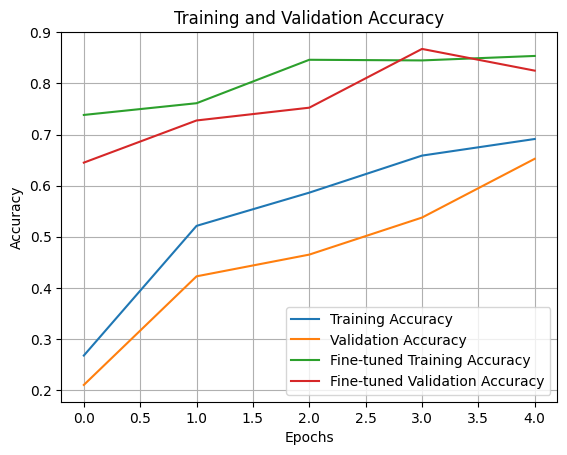

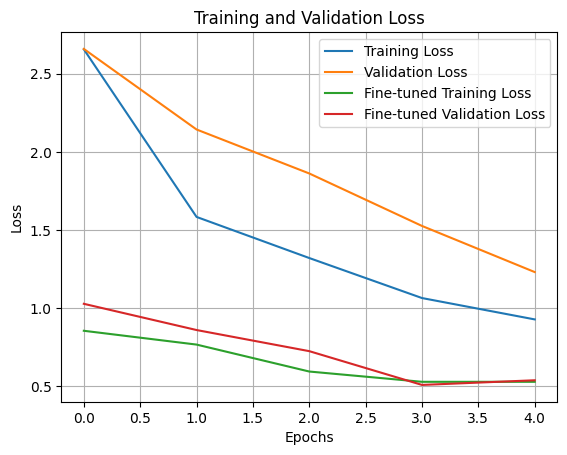

In [11]:
# Plot accuracy and loss curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuned Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuned Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuned Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

## 10. Visual Predictions on Sample Test Images

Finally, I pick a few images from the test set and run them through the model to see predictions side by side with the actual labels.

The function reads the true class directly from the folder name (so no hardcoded labels), preprocesses the image the same way as training, and shows the result visually.

Class Index Mapping: {'apple_6': 0, 'apple_braeburn_1': 1, 'apple_crimson_snow_1': 2, 'apple_golden_1': 3, 'apple_golden_2': 4, 'apple_golden_3': 5, 'apple_granny_smith_1': 6, 'apple_hit_1': 7, 'apple_pink_lady_1': 8, 'apple_red_1': 9, 'apple_red_2': 10, 'apple_red_3': 11, 'apple_red_delicios_1': 12, 'apple_red_yellow_1': 13, 'apple_rotten_1': 14, 'cabbage_white_1': 15, 'carrot_1': 16, 'cucumber_1': 17, 'cucumber_3': 18, 'eggplant_violet_1': 19, 'pear_1': 20, 'pear_3': 21, 'zucchini_1': 22, 'zucchini_dark_1': 23}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


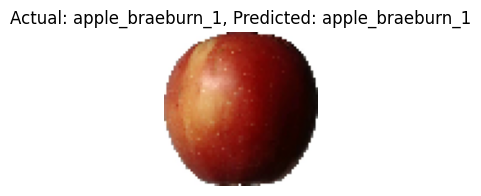

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


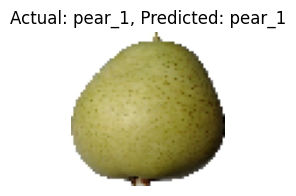

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


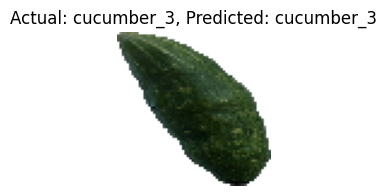

In [12]:
import os
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

# Initialize counters for actual and predicted classes
actual_count = Counter()
predicted_count = Counter()

# Function to get class name from predicted index
def get_class_name_from_index(predicted_index, class_index_mapping):
    """Convert predicted index to class name."""
    for class_name, index in class_index_mapping.items():
        if index == predicted_index:
            return class_name
    return "Unknown"  # Default if index is not found

# Define the function for visualization
def visualize_prediction_with_actual(img_path, class_index_mapping):
    # Extract the true label dynamically from the directory structure
    class_name = os.path.basename(os.path.dirname(img_path))  # Extract folder name (class)
    
    # Load and preprocess the image
    img = load_img(img_path, target_size=(64, 64)) 
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction, axis=-1)[0]
    predicted_class_name = get_class_name_from_index(predicted_index, class_index_mapping)

    # Update the counters
    actual_count[class_name] += 1
    predicted_count[predicted_class_name] += 1

    # Visualize the image with predictions
    plt.figure(figsize=(2, 2), dpi=100)
    plt.imshow(img)
    plt.title(f"Actual: {class_name}, Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

# Retrieve class index mapping from the training generator
class_index_mapping = train_generator.class_indices
print("Class Index Mapping:", class_index_mapping)  # Debugging: Check the mapping

# Define a list of image paths without hardcoded labels
sample_images = [
    'fruits-360-original-size/fruits-360-original-size/Test/apple_braeburn_1/r0_11.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/pear_1/r0_103.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/cucumber_3/r0_103.jpg',
]

# Run the predictions and visualization
for img_path in sample_images:
    visualize_prediction_with_actual(img_path, class_index_mapping)


##### If there is an incorrect prediction during testing, the following factors could contribute to the misclassification:

Class Similarity: Visually similar fruit classes (e.g., apple types) can confuse the model.

Insufficient Data: Imbalanced datasets with fewer samples for certain classes may cause underfitting.

Limited Training: Fine-tuning fewer layers might not capture sufficient class-specific features.

Data Augmentation Impact: Aggressive augmentations may distort key features, reducing accuracy for specific images.


## Conclusion

This project shows how powerful transfer learning is for image classification tasks, especially when you don't have a huge dataset or a GPU. By reusing VGG16's convolutional features — which it learned from millions of images — I got to 86% accuracy on 24 fruit classes in just 10 epochs of training.

The two-phase approach (freeze → fine-tune) is a standard and effective strategy: the first phase teaches the custom head to work with VGG16's features, and the second phase lets the deeper layers refine themselves for the specific task.